In [1]:
import time_series_transform as tst
import pandas as pd
import pandas_ta as ta
import numpy as np

In [2]:
port = tst.Stock_Transformer.from_stock_engine_period(
    symbols = ['GOOGL','NDAQ',"GOLD"],
    period = '5y',
    engine = 'yahoo'
)

In [3]:
strategy = ta.Strategy(
    name= 'mystrategy',
    ta=[
        {"kind": "ema", "length": 50},
        {"kind": "ema", "length": 7},
        {"kind": "ema", "length": 20},
        {"kind": "bbands", "length": 20},
        {"kind": "bbands", "length": 50},
        {"kind": "bbands", "length": 30},
        {"kind": "rsi","prefix":"rsi"},
        {"kind": "macd", "fast": 8, "slow": 21},
    ]
)
port = port.get_technial_indicator(strategy)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s finished


In [4]:
traget_list = ['Open','High','Low','Close','Volume','EMA_50','EMA_7',
     'EMA_20','BBL_20_2.0','BBM_20_2.0','BBU_20_2.0','BBL_50_2.0',
    'BBM_50_2.0',
    'BBU_50_2.0',
    'BBL_30_2.0',
    'BBM_30_2.0',
    'BBU_30_2.0',
    'rsi_RSI_14',
    'MACD_8_21_9',
    'MACDh_8_21_9',
    'MACDs_8_21_9']
port = port.make_lag_sequence(
    traget_list,
    windowSize = 60,
    lagNum = 1,
    suffix = '_lag_'
)
port = port.make_lead_sequence(traget_list,5,1,'_lead_')
port = port.dropna()
for t in traget_list:
    port = port.remove_feature(t)
df = port.to_pandas(True)
trans = tst.Time_Series_Transformer.from_pandas(df,'Date',None)
lag_cols = df.columns[df.columns.str.contains('_lag_')]
lead_cols = df.drop('Close_lead_5_GOOGL',axis =1).columns[df.drop('Close_lead_5_GOOGL',axis =1).columns.str.contains('_lead_')]
trans = trans.make_stack_sequence(list(lag_cols),'Lag_data')
for i in list(lead_cols):
    trans = trans.remove_feature(i)
for i in list(lag_cols):
    trans = trans.remove_feature(i)  

In [5]:
df = trans.to_pandas()
test = df.tail(100)
train = df.drop(test.index)

In [19]:
trainX = np.array(train['Lag_data'].tolist())
trainY = np.array(train['Close_lead_5_GOOGL'].tolist(),dtype=np.float32)
testX = np.array(test['Lag_data'].tolist())
testY = np.array(test['Close_lead_5_GOOGL'].tolist())

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from time_series_transform import tfDataset_adopter as tda
from sklearn.metrics import classification_report,confusion_matrix

In [70]:
inputs = keras.Input(shape=(63,60),name = "Close_seq")
x = layers.LayerNormalization()(inputs)
x = layers.LSTM(5)(x)
# output = layers.Flatten(name="change")(x)
# x = layers.Dense(50, activation="relu", name="dense_2")(x)
# outputs = layers.Dense(5, name="change")(x)
model = keras.Model(inputs=inputs, outputs=x)
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01),
    loss = tf.keras.losses.Huber()
)

In [71]:
model.fit(
    trainX,
    trainY,
    epochs = 300,
    batch_size =1046,
    validation_split = 0.2
)

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 1022.1752 - val_loss: 1365.1305
Epoch 2/300
1/1 [==============================] - 0s 112ms/step - loss: 1021.9178 - val_loss: 1365.0347
Epoch 3/300
1/1 [==============================] - 0s 109ms/step - loss: 1021.8062 - val_loss: 1364.9741
Epoch 4/300
1/1 [==============================] - 0s 109ms/step - loss: 1021.7426 - val_loss: 1364.9399
Epoch 5/300
1/1 [==============================] - 0s 109ms/step - loss: 1021.6948 - val_loss: 1364.9113
Epoch 6/300
1/1 [==============================] - 0s 112ms/step - loss: 1021.6555 - val_loss: 1364.8795
Epoch 7/300
1/1 [==============================] - 0s 111ms/step - loss: 1021.6138 - val_loss: 1364.8365
Epoch 8/300
1/1 [==============================] - 0s 113ms/step - loss: 1021.5635 - val_loss: 1364.7778
Epoch 9/300
1/1 [==============================] - 0s 116ms/step - loss: 1021.5032 - val_loss: 1364.7098
Epoch 10/300
1/1 [==============================] - 0s 112

KeyboardInterrupt: 

In [55]:
prd = model.predict(testX)

<AxesSubplot:>

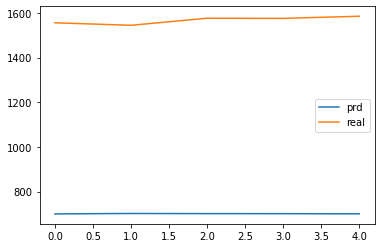

In [63]:
pd.DataFrame({"prd":prd[2],"real":testY[2]}).plot()